<a href="https://colab.research.google.com/github/luciamartinf/BigData/blob/main/COVNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References

Introduction: https://www.mayoclinic.org/es-es/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=La%20neumon%C3%ADa%20es%20una%20infecci%C3%B3n,escalofr%C3%ADos%20y%20dificultad%20para%20respirar.

Code: https://www.kaggle.com/code/karnikakapoor/pneumonia-diagnosis-convnet-model

## Introduction


Pneumonia is an infection that inflames the air sacs of one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing coughing up phlegm or pus, fever, chills and shortness of breath. Various microorganisms, such as bacteria, viruses and fungi, can cause pneumonia.

Signs and symptoms of pneumonia vary from moderate to severe and depend on several factors, such as the type of germ that caused the infection, age and general health. Moderate signs and symptoms are often similar to those of a cold or the flu, but last longer.

Signs and symptoms of pneumonia may include the following:
- Chest pain when breathing or coughing.
- Disorientation or changes in mental perception (in adults age 65 and older)
- Cough that may produce phlegm
- Fatigue
- Fever, sweating, and shaking chills
- Lower than normal body temperature (in adults over age 65 and people with weak immune systems)
- Nausea, vomiting or diarrhea
- Shortness of breath


## Import libraries


In [3]:
# Importing all the libraries 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings('ignore')


## Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define path to the data directory
dir_alldata = Path('/content/drive/MyDrive/Colab Notebooks/chest_xray')
# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

In [6]:
img_width, img_height = 150,150
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150),batch_size=batch_size, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")
 
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")
 

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Data visualization

Plot Random Normal Images

Printing three Normal random images 
IM-0039-0001.jpeg
IM-0022-0001.jpeg
NORMAL2-IM-0246-0001.jpeg


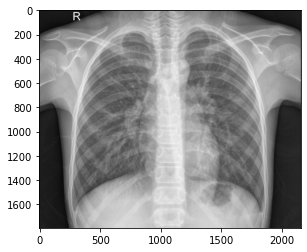

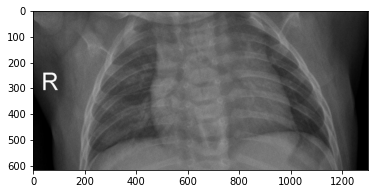

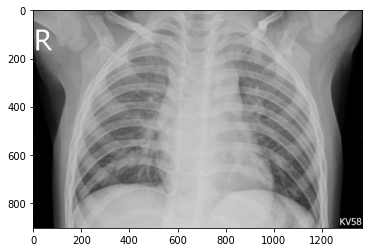

In [7]:
# Three Random Normal CXR Images from the dataset
import os, random

folder_N=r"/content/drive/MyDrive/Colab Notebooks/chest_xray/test/NORMAL"

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 

Plot Random Pneumonia Images

Printing three Normal random images 
person91_bacteria_448.jpeg
person130_bacteria_626.jpeg
person122_bacteria_583.jpeg


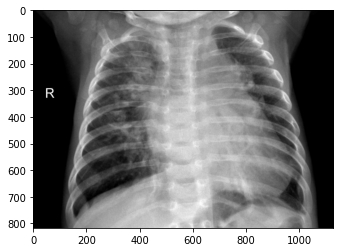

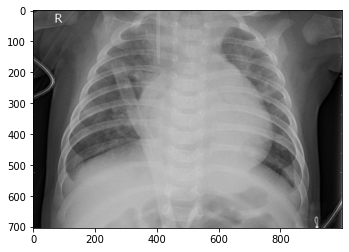

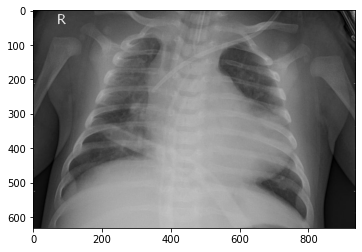

In [8]:
# Three Random Pneumonia CXR Images from the dataset
import os, random

folder_N=r"/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA"

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 

## Exploratory analysis
Plot Count of Positive and Negative Cases

Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

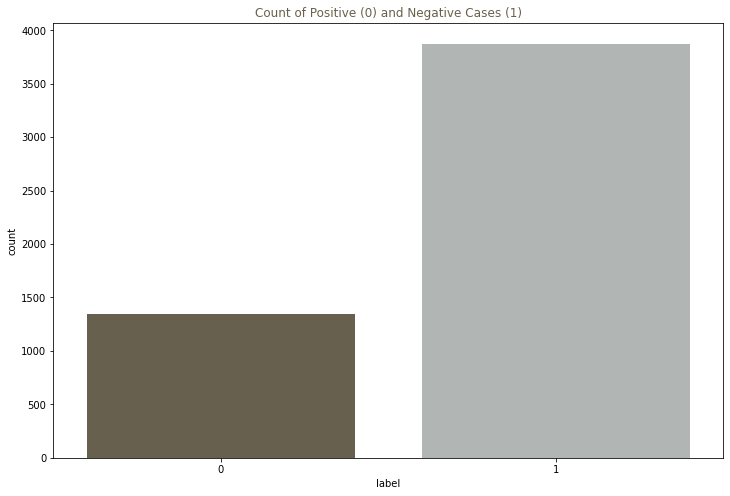

In [9]:
import pandas as pd
# To plot the count plot I am changing the dataset into a pandas dataframe
# Get the list of all the images
normal = normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)", color="#6B614B")


## Model building (COVNET)


The following steps were involved in the **convolutional neural network** model building:

- Initialising the Convnet

- Defining by adding layers

- Compiling the Convnet

- Train the Convnet

- Testing on the test set

In [10]:
# Initialising the convnet and defining it by adding layers
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [11]:
# Compiling the Convnet
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
# Train de convnet
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_sample//batch_size, epochs=epochs,validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.7460

50/50 [==============================] - 196s 4s/step - loss: 0.5972 - accuracy: 0.7460 - val_loss: 0.8403 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 127s 3s/step - loss: 0.4278 - accuracy: 0.7890
Epoch 3/50
50/50 [==============================] - 104s 2s/step - loss: 0.3627 - accuracy: 0.8112
Epoch 4/50
50/50 [==============================] - 99s 2s/step - loss: 0.3494 - accuracy: 0.8450
Epoch 5/50
50/50 [==============================] - 83s 2s/step - loss: 0.2828 - accuracy: 0.8785
Epoch 6/50
50/50 [==============================] - 74s 1s/step - loss: 0.2699 - accuracy: 0.8980
Epoch 7/50
50/50 [==============================] - 68s 1s/step - loss: 0.2435 - accuracy: 0.9020
Epoch 8/50
50/50 [==============================] - 61s 1s/step - loss: 0.2660 - accuracy: 0.8876
Epoch 9/50
50/50 [==============================] - 56s 1s/step - loss: 0.2488 - accuracy: 0.8840
Epoch 10/50
50/50 [==============================] - 53s 1s/step - loss: 0.2535 - ac

In [ ]:
#Testing on the test set
test_accuracy = model.evaluate_generator(test_generator)

## Model evaluation (COVNET)

In [15]:
# Evaluating Test accuracy
print('The accuracy on test set :',test_accuracy[1]*100 )

The accuracy on test set : 84.77563858032227
